Latent Variable Model

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import statsmodels.api as sm

rng = np.random.default_rng()

import pymc as pm
import arviz as az
# import pymc_experimental as pmx

In [17]:
x_min, x_max = -5, 5

def mu_true(x):
    return 1.0/(1.0+np.exp(-x))

def sigma_true(x):
    return 0.5+0.5/(1.0+x**2)

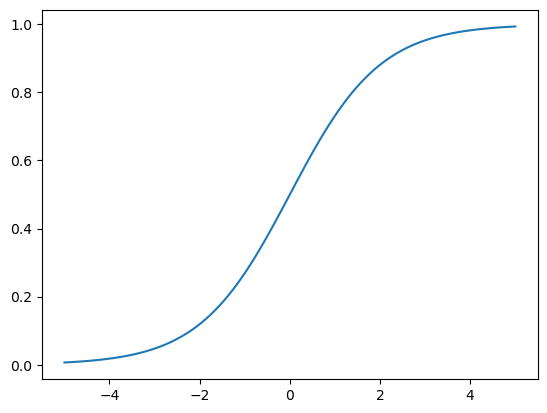

In [18]:
x_vals = np.linspace(x_min,x_max,100)
plt.plot(x_vals,mu_true(x_vals))

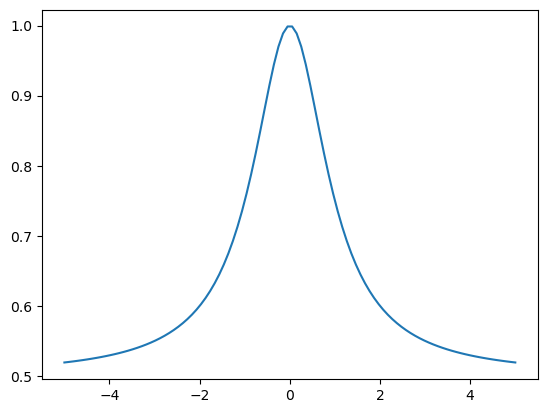

In [19]:
plt.plot(x_vals,sigma_true(x_vals))

In [20]:
x_sample = np.linspace(x_min,x_max,20)

In [21]:
n_samples = 10

y_obs = []

for x in x_sample:
    mu = mu_true(x)
    sigma = sigma_true(x)

    y = rng.normal(mu, sigma, size=n_samples)
    y_obs.append(y)

x_obs = np.tile(x_sample,(n_samples,1)).T
y_obs = np.array(y_obs)


y_obs_mean = y_obs.mean()
y_obs_std = y_obs.std()
z_obs = (y_obs - y_obs_mean)/y_obs_std

In [87]:
y_mean_est = y_obs.mean(axis=1)
y_std_est = y_obs.std(axis=1)
y_mean_se = y_std_est / np.sqrt(n_samples)
alpha = 0.05
z_alpha = sp.stats.t.ppf(1-alpha/2, n_samples-1)

<ErrorbarContainer object of 3 artists>

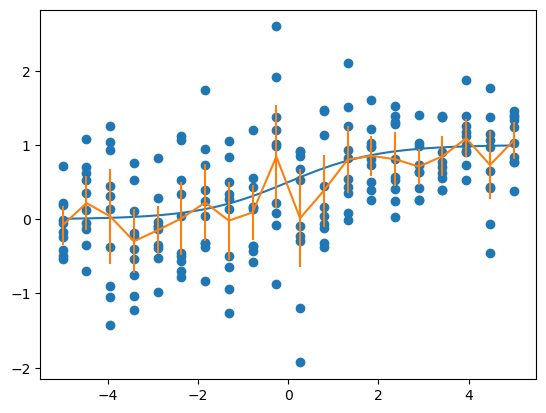

In [88]:
plt.scatter(x_obs,y_obs)
plt.plot(x_vals, mu_true(x_vals))
plt.errorbar(x_sample,y_mean_est,yerr = z_alpha * y_mean_se)

1.9602276050814773

In [28]:
X = x_obs.ravel().reshape(-1,1)

In [58]:
with pm.Model() as model:
    # l = 2.0

    ls_loc = pm.InverseGamma("ls_loc", mu = 2.0, sigma = 2.0)
    ls_scale = pm.InverseGamma("ls_scale", mu = 2.0, sigma = 2.0)
    s2_loc = pm.Gamma("s2_loc", alpha = 2, beta = 1)
    s2_scale = pm.Gamma("s2_scale", alpha = 2, beta = 1)
    cov_loc = s2_loc**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls_loc) + pm.gp.cov.WhiteNoise(sigma = 1e-6)
    cov_scale = s2_scale**2 * pm.gp.cov.ExpQuad(input_dim = 1, ls = ls_scale) + pm.gp.cov.WhiteNoise(sigma = 1e-6)

    # cov_loc =  η**2 * pm.gp.cov.ExpQuad(1, ls=5.0) + pm.gp.cov.WhiteNoise(sigma=1e-6)
    # cov_scale = pm.gp.cov.ExpQuad(1, ls=5.0)
    # cov_loc = pm.gp.cov.Exponential(1, ls=5.0)
    # cov_scale = pm.gp.cov.Exponential(1, ls=5.0)

    gp_loc = pm.gp.Latent(cov_func = cov_loc)
    gp_log_scale = pm.gp.Latent(cov_func = cov_scale)

    mu = gp_loc.prior('mu', X = X)
    log_sigma = gp_log_scale.prior('log_sigma', X = X)

    z = pm.Normal('z', mu = mu, sigma = pm.math.exp(log_sigma), observed = z_obs.ravel())
    # y = z * y_obs_std + y_obs_mean

    # vi_approx = pm.fit()
    # trace = vi_approx.sample(1000)
    trace = pm.sample(1000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ls_loc, ls_scale, s2_loc, s2_scale, mu_rotated_, log_sigma_rotated_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1880 seconds.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.


array([<Axes: title={'center': 'ls_loc'}>,
       <Axes: title={'center': 'ls_scale'}>,
       <Axes: title={'center': 's2_loc'}>,
       <Axes: title={'center': 's2_scale'}>], dtype=object)

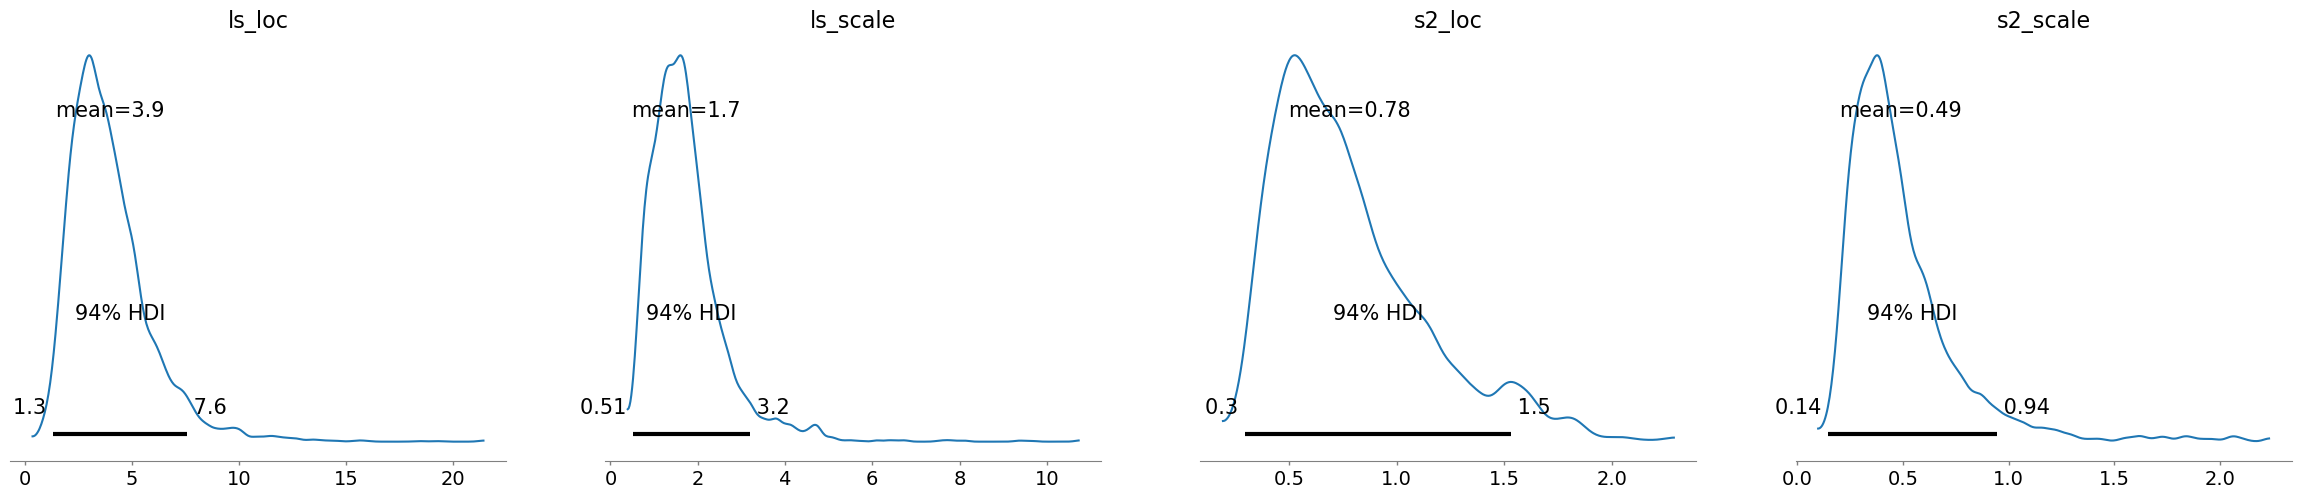

In [59]:
az.plot_posterior(trace, var_names = ["ls_loc", "ls_scale", "s2_loc", "s2_scale"])

In [60]:
Xpred = x_vals.reshape(-1,1)

In [61]:
with model:
    mu_pred = gp_loc.conditional("mu_pred2", Xnew=Xpred)
    log_sigma_pred = gp_log_scale.conditional("log_sigma_pred2", Xnew=Xpred)
    posterior_pred = pm.sample_posterior_predictive(trace, var_names=["mu_pred2", "log_sigma_pred2"])

In [62]:
# az.plot_trace(idata)

In [63]:
y_mean = y_obs.mean(axis=1)
y_sigma = np.std(y_obs,axis=1)

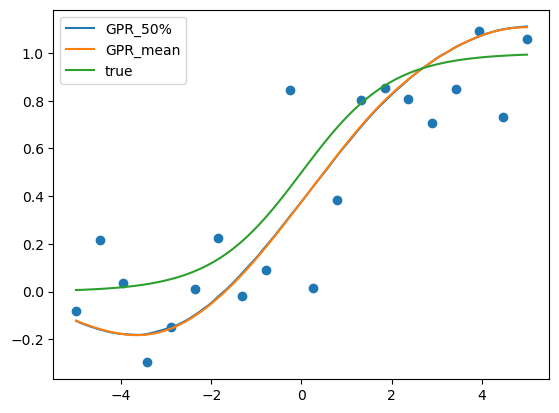

In [64]:
plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred2'].median(axis=(0,1))+y_obs_mean,label='GPR_50%')
plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred2'].mean(axis=(0,1))+y_obs_mean,label='GPR_mean')
plt.plot(x_vals, mu_true(x_vals),label='true')
plt.scatter(x_sample,y_mean)
plt.legend()

In [ ]:
np.percentile

In [71]:
alpha = 0.05
latent_mu_median = posterior_pred.posterior_predictive['mu_pred2'].mean(axis=(0,1))+y_obs_mean
latent_mu_L = np.quantile(posterior_pred.posterior_predictive['mu_pred2'],alpha/2, axis=(0,1))+y_obs_mean
latent_mu_U = np.quantile(posterior_pred.posterior_predictive['mu_pred2'], 1-alpha/2, axis=(0,1))+y_obs_mean

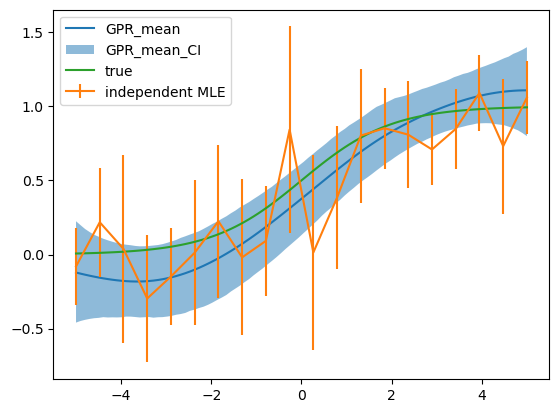

In [89]:
# plt.scatter(x_obs,y_obs)

plt.plot(x_vals,posterior_pred.posterior_predictive['mu_pred2'].mean(axis=(0,1))+y_obs_mean,label='GPR_mean')
plt.fill_between(x_vals,latent_mu_L,latent_mu_U,alpha=0.5,label='GPR_mean_CI')
plt.errorbar(x_sample,y_mean_est,yerr = z_alpha * y_mean_se,label='independent MLE')
plt.plot(x_vals, mu_true(x_vals),label='true')
plt.legend()

Smoother results with more accuracy (except for the edges)


In [91]:
sigma_pred = np.exp(posterior_pred.posterior_predictive['log_sigma_pred2'])*y_obs_std

latent_sigma_median = np.quantile(sigma_pred,0.5, axis=(0,1))
latent_sigma_L = np.quantile(sigma_pred, alpha/2, axis=(0,1))
latent_sigma_U = np.quantile(sigma_pred, 1-alpha/2, axis=(0,1))

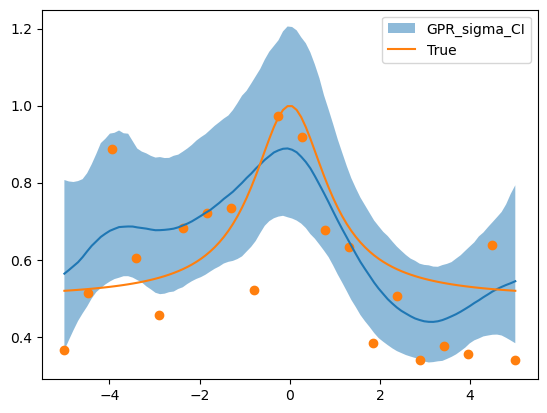

In [96]:



plt.plot(x_vals,latent_sigma_median)
plt.fill_between(x_vals,latent_sigma_L,latent_sigma_U,alpha=0.5,label='GPR_sigma_CI')

plt.scatter(x_sample,y_sigma)
plt.plot(x_vals, sigma_true(x_vals),label='True')
plt.legend()